## Face and Facial Keypoint detection

In the next python cell we load in required libraries.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory. Faces are then detected using Open CV HAAR Cascades 

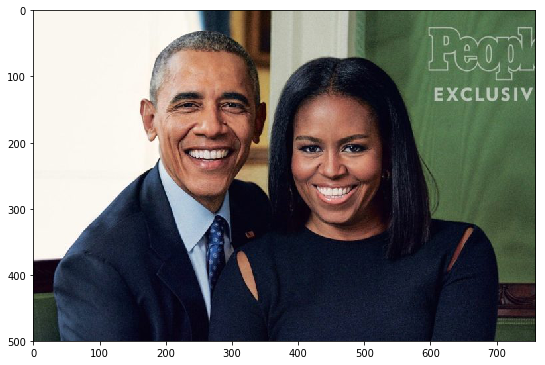

In [3]:
import cv2
# load in color image for face detection
image = cv2.imread('images/obamas.jpg')

# switch red and blue color channels 

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

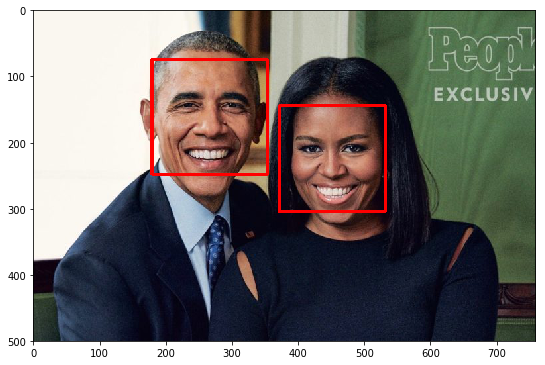

In [4]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in the previously trained CNN model

In [5]:
import torch

from models import Net

net = Net()
net.double()
net.load_state_dict(torch.load('saved_models/model_1.pth'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4))
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.2)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.2)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout2d(p=0.2)
  (fc4): Linear(in_features=4096, out_features=500, bias=True)
  (batchnorm4): BatchNorm1d(500, eps=1e-05, momentum=0

## Keypoint detection

In [6]:
import data_load
print(cv2.__version__)
image_copy = np.copy(image) 
rois = []
numpy_rois = []
all_key_points = []

# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:

    # Select the region of interest that is the face in the image 
    roi = image_copy[y:y+h, x:x+w]
    
    ## Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

    ## Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = roi/255.0
    
    ## Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    h, w = roi.shape[:2]
    if h > w:
        new_h, new_w = 224 * h / w, 224
    else:
        new_h, new_w = 224, 224 * w / h
    new_h, new_w = int(new_h), int(new_w)
    roi = cv2.resize(roi, (new_w, new_h))
    numpy_rois.append(roi)
    
    ## Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    roi = roi.reshape(roi.shape[0], roi.shape[1], 1, 1)
    roi = roi.transpose((3, 2, 0, 1))
    roi = torch.from_numpy(roi)
    
    ## Make facial keypoint predictions using your loaded, trained network 
    rois.append(roi)
    net.eval()
    key_point_prediction = net(roi)
    all_key_points.append(key_point_prediction)


3.2.0


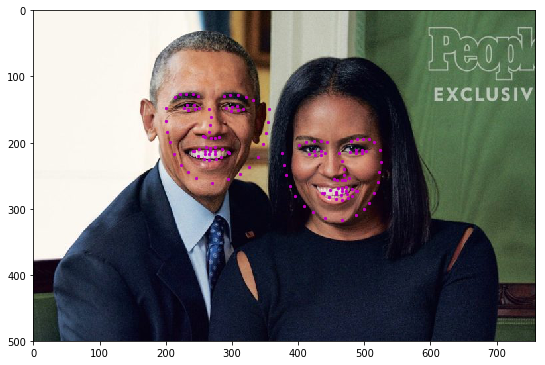

In [7]:
def show_keypoints_of_rois(image, faces, all_key_points):
    """Show image with keypoints"""   
    
    plt.figure(figsize=(9,9))
    plt.imshow(image)
    i=0
    for (x,y,w,h), relative_key_points in zip(faces, all_key_points):      
        
        # transform key points to numpy ara
        relative_key_points = relative_key_points.data.numpy()
        
        # reshape to 68 x 2 pts
        relative_key_points.resize((68,2))

        # undo normalization of keypoints  
        relative_key_points = relative_key_points * 100.0 + 100
        
        # scale keypoints to w.r.t. actual size of region of interest
        relative_key_points[:] = relative_key_points[:]*(w/224)
        
        # Caculates coordinate of keypoints in image
        absolute_keypoints =  relative_key_points[:]+[x,y]
        
        # Plot Keypoints on top of Picture
        plt.scatter(absolute_keypoints[:, 0], absolute_keypoints[:, 1], s=20, marker='.', c='m')
      
    # Display the plot 
    plt.show()
    
# Call function to print out results
show_keypoints_of_rois(image, faces, all_key_points)